In [1]:
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
torch.manual_seed(42)


In [4]:
df = pd.read_csv('./fashion-mnist_train.csv')

In [5]:
df.shape

(60000, 785)

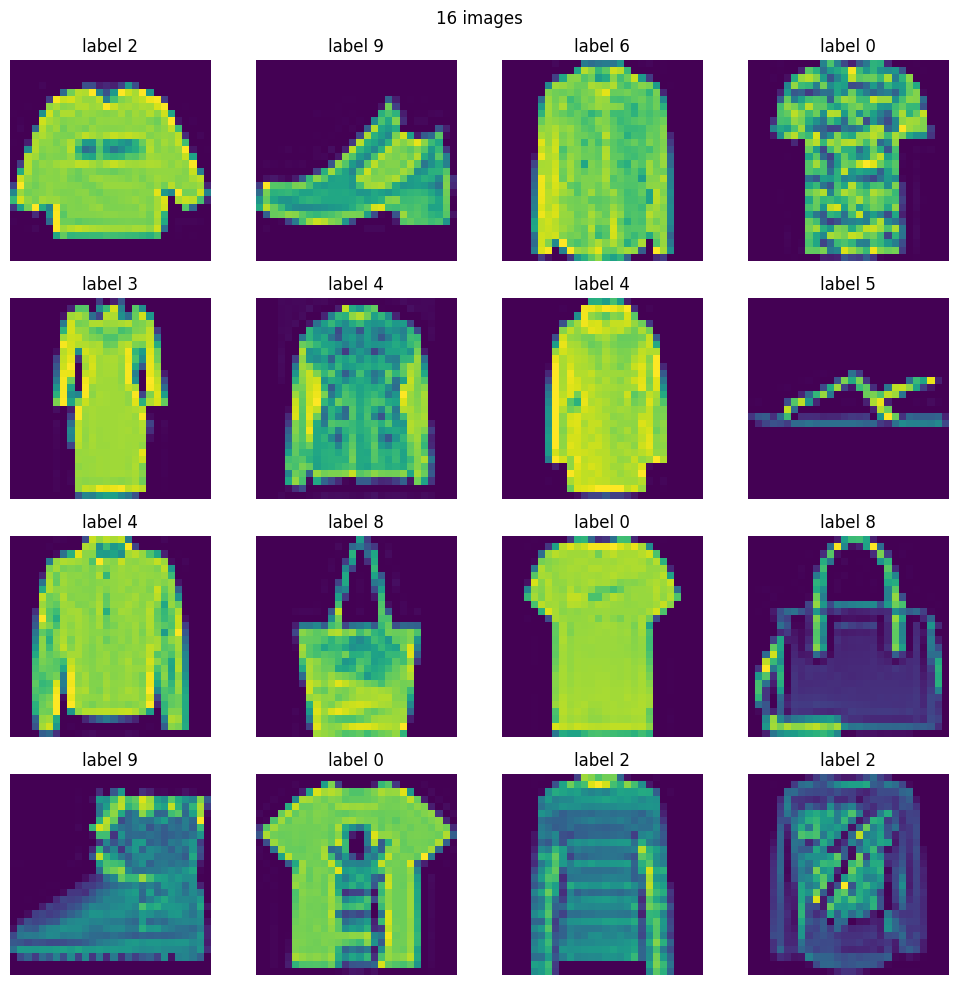

In [6]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("16 images")
for i,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"label {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,1])
plt.show()

In [7]:
x = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [9]:
xtrain = xtrain/255.0
xtest = xtest/255.0
xtrain.shape

(48000, 784)

In [10]:
class customdataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels,dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx],self.labels[idx]


In [11]:
traindataset = customdataset(xtrain,ytrain)
len(traindataset)

48000

In [12]:
traindataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [13]:
testdataset = customdataset(xtest,ytest)
len(testdataset)

12000

In [14]:
trainloader = DataLoader(traindataset,batch_size=32,shuffle=True,pin_memory=True)
testloader = DataLoader(testdataset,batch_size=32,shuffle=False,pin_memory=True)

In [17]:
class NewNN(nn.Module):
    def __init__(self,input_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64,10),
        )

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
epochs = 100
lr = 0.1

In [19]:
model = NewNN(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr)

In [21]:
for epoch in range(epochs):
    for batchfeatures,batchlabels in trainloader:
        batchfeatures = batchfeatures.to(device)
        batchlabels = batchlabels.to(device)
        output = model(batchfeatures).to(device)
        loss = criterion(output,batchlabels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"\n epoch {epoch+1}, loss: {loss.item():.4f}")


/Users/sudharmas/pytorch_basics/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



 epoch 1, loss: 0.0495

 epoch 2, loss: 0.2724

 epoch 3, loss: 0.1400

 epoch 4, loss: 0.0814

 epoch 5, loss: 0.2241

 epoch 6, loss: 0.0741

 epoch 7, loss: 0.1859

 epoch 8, loss: 0.0648

 epoch 9, loss: 0.1014

 epoch 10, loss: 0.0762

 epoch 11, loss: 0.0235

 epoch 12, loss: 0.0454

 epoch 13, loss: 0.3334

 epoch 14, loss: 0.0962

 epoch 15, loss: 0.3112

 epoch 16, loss: 0.1538

 epoch 17, loss: 0.1013

 epoch 18, loss: 0.0640

 epoch 19, loss: 0.1117

 epoch 20, loss: 0.2067

 epoch 21, loss: 0.0988

 epoch 22, loss: 0.0511

 epoch 23, loss: 0.0142

 epoch 24, loss: 0.1144

 epoch 25, loss: 0.0083

 epoch 26, loss: 0.1319

 epoch 27, loss: 0.0082

 epoch 28, loss: 0.1291

 epoch 29, loss: 0.0169

 epoch 30, loss: 0.0477

 epoch 31, loss: 0.0608

 epoch 32, loss: 0.0066

 epoch 33, loss: 0.0667

 epoch 34, loss: 0.0239

 epoch 35, loss: 0.0033

 epoch 36, loss: 0.0215

 epoch 37, loss: 0.0306

 epoch 38, loss: 0.1754

 epoch 39, loss: 0.1436

 epoch 40, loss: 0.0379

 epoch 4

In [22]:
model.eval()

NewNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
total =0
correct = 0
with torch.no_grad():
    for batchfeatures,batchlabels in testloader:
        batchfeatures = batchfeatures.to(device)
        batchlabels = batchlabels.to(device)
        output = model(batchfeatures).to(device)
        _, predicted = torch.max(output.data,1)
        total += batchlabels.shape[0]
        correct = correct + predicted.eq(batchlabels).sum().item()
print(correct/total)

0.9235833333333333


In [24]:
total =0
correct = 0
with torch.no_grad():
    for batchfeatures,batchlabels in trainloader:
        batchfeatures = batchfeatures.to(device)
        batchlabels = batchlabels.to(device)
        output = model(batchfeatures).to(device)
        _, predicted = torch.max(output.data,1)
        total += batchlabels.shape[0]
        correct = correct + predicted.eq(batchlabels).sum().item()
print(correct/total)

/Users/sudharmas/pytorch_basics/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


0.9986666666666667


In [ ]:
#test acc =92
#train ac =99
# gap - 7 percent

In [ ]:
# model = MyNN(xtrain.shape[1]).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(),lr=lr,weight_decay=1e-4)

In [ ]:
#test acc - 89
#train acc - 94
# gap - 5 percent

In [ ]:
# def objective(trial):
#     num_hidden_layers = trial.suggest_int("num_hidden_layers",1,5)
#     neurons_per_layer = trial.suggest_int("neurons_per_layer",8,128,step=8)
#     epochs = trial.suggest_int("epochs",10,50,step=10)
#     learning_rate = trial.suggest_float("learning_rate",1e-5,1e-1,log=True)
#     dropout = trial.suggest_float("dropout",0.1,0.5,step=0.1)
#     batch_size = trial.suggest_categorical("batch_size",[16,32,64,128])
#     optimizer = trial.suggest_categorical("optimizer",["SGD","Adam","RMSprop"])
#     weight_decay = trial.suggest_float("weight_decay",1e-5,1e-3,log=True)
#
#     trainloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True,pin_memory=True)
#     testloader = DataLoader(testdataset,batch_size=batch_size,shuffle=False,pin_memory=True)
#
#     input_dim =784
#     output_dim = 10
#     model = NewNN(input_dim,output_dim,neurons_per_layer,num_hidden_layers,dropout)
#     model.to(device)
#
#     criterion = nn.CrossEntropyLoss()
#     if optimizer == "SGD":
#         optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
#     elif optimizer == "Adam":
#         optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
#     else:
#         optimizer = optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
#
#     for epoch in range(epochs):
#         for batchfeatures,batchlabels in trainloader:
#             batchfeatures = batchfeatures.to(device)
#             batchlabels = batchlabels.to(device)
#             output = model(batchfeatures).to(device)
#             loss = criterion(output,batchlabels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#
#     model.eval()
#
#     total =0
#     correct = 0
#     with torch.no_grad():
#         for batchfeatures,batchlabels in trainloader:
#             batchfeatures = batchfeatures.to(device)
#             batchlabels = batchlabels.to(device)
#             output = model(batchfeatures).to(device)
#             _, predicted = torch.max(output.data,1)
#             total += batchlabels.shape[0]
#             correct = correct + predicted.eq(batchlabels).sum().item()
#         acc = correct/total
#     return acc


In [ ]:
# import optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective,n_trials=10)

In [ ]:
# study.best_params,study.best_value